In [1]:
!pip install -q -U transformers matplotlib pandas scikit-learn seaborn
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import json
import os
from datetime import datetime
from glob import glob
import torch.nn.functional as F
import random
import importlib
from collections import defaultdict
from enhanced_hooking import get_activations, add_activations_and_generate, clear_hooks
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

In [346]:
importlib.reload(enhanced_hooking)
import enhanced_hooking
from enhanced_hooking import get_activations, add_activations_and_generate, clear_hooks

In [2]:
#### Load the model
def load_model(model_path, device, center_weights=True):
    model = AutoModelForCausalLM.from_pretrained(model_path).to(device)#, torch_dtype=torch.float16
    if center_weights:
        for name, param in model.named_parameters():
            if '.'.join(name.split('.')[-2:]) in ['wte.weight','wpe.weight','c_proj.weight','c_proj.bias']:
                param.data -= param.data.mean()
                print(name, param.data.mean(), param.size())
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.tokenizer = tokenizer
    #model.tokenizer.padding_side = "left" #for batching; right (default in gpt2) for training, left for generation
    model.tokenizer.pad_token_id = model.tokenizer.eos_token_id 
    return model

model=None
import gc
gc.collect()
torch.cuda.empty_cache()
_ = torch.set_grad_enabled(False)
model_path: str = "meta-llama/Llama-2-7b-chat-hf" #even on an A40 I have to load 13b in half precision
device: str = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu" #need to upgrade MacOS first
#device: str = "cuda" if torch.cuda.is_available() else "cpu"
center_weights=False

model = load_model(model_path, device, center_weights=center_weights)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [50]:
### Load in data
if "gpt" in model_path:
    user_tag, asst_tag = "|<end_of_text>|", ""
    model_numlayers = model.config.n_layer
else: #/llama/mistral
    user_tag, asst_tag = "[INST] ", " [/INST]"
    model_numlayers = model.config.num_hidden_layers

strip_quotes = lambda s: s[1:-1] if len(s) > 1 and (s.startswith('"') and s.endswith('"') or s.startswith("'") and s.endswith("'")) else s

positive_personas = ["honest"]
negative_personas = ["untruthful"]
pos_label = "(A)"
neg_label = "(B)"
key_token_offset = 2###1
pair_statement=False # pair labels

df = pd.read_csv("./facts_true_false.csv") #train
true_statements = df[df['label'] == 1]['statement'].values.tolist()
false_statements = df[df['label'] == 0]['statement'].values.tolist()

def template(persona: str, label: str, suffix: str) -> str:
    return f"{user_tag}Question: Is the following claim true or false? \"{strip_quotes(suffix)}\"\n\nChoices:\n (A) True\n (B) False\n\nAnswer:{asst_tag} {label}"
#    return f"{user_tag}Is the following claim true?\n\"{strip_quotes(suffix)}\"{asst_tag}{label}"

letters_pos = np.array(["T" for _ in range(len(dataset)//2)] + ["F" for _ in range(len(dataset)//2)])#[item["matching_text"][-2].replace("e", "Y") for item in samples]
letters_neg = np.array(["F" for _ in range(len(dataset)//2)] + ["T" for _ in range(len(dataset)//2)])#[item["non_matching_text"][-2].replace("e", "Y") for item in samples]

dataset = []
if pair_statement:
    for statement in true_statements:
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            dataset.append((template(positive_persona, pos_label, statement), template(negative_persona, neg_label, statement))
            )
    for statement in false_statements:
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            dataset.append((template(positive_persona, neg_label, statement), template(negative_persona, pos_label, statement))
            )

else:
    for truth, lie in zip(true_statements, false_statements):
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            dataset.append((template(positive_persona, pos_label, truth), template(negative_persona, pos_label, lie)))
    for truth, lie in zip(true_statements, false_statements):# just to keep the letters ordering consistent
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            dataset.append((template(positive_persona, neg_label, lie), template(negative_persona, neg_label, truth)))

print(len(dataset))
for i in range(2):
    print(f"dataset[{i}]:", *dataset[i])
for i in range(len(dataset)-2, len(dataset)):
    print(f"dataset[{i}]:", *dataset[i])


df = pd.read_csv("./gpt4_facts.csv") #eval
true_statements = df[(df['label'] == '1') | (df['label'] == 1)]['statement'].values.tolist()
false_statements = df[(df['label'] == '0') | (df['label'] == 0)]['statement'].values.tolist()

def template_test(suffix: str) -> str:
    return f"{user_tag}Question: Is the following claim true or false? {suffix}\n\nChoices:\n (A) True\n (B) False\n\nAnswer:{asst_tag}"
#    return f"{user_tag}Is the following claim true?\n\"{strip_quotes(suffix)}\"{asst_tag}"

prompts_to_be_steered = []
for statement in df['statement']:
    prompts_to_be_steered.append(template_test(statement))
print(len(prompts_to_be_steered))
for i in range(2):
    print(f"prompts_to_be_steered[{i}]:", prompts_to_be_steered[i])
for i in range(len(prompts_to_be_steered)-2, len(prompts_to_be_steered)):
    print(f"prompts_to_be_steered[{i}]:", prompts_to_be_steered[i])


612
dataset[0]: [INST] Question: Is the following claim true or false? "The Earth's atmosphere protects us from harmful radiation from the sun."

Choices:
 (A) True
 (B) False

Answer: [/INST] (A) [INST] Question: Is the following claim true or false? "The largest flower in the world is the daisy."

Choices:
 (A) True
 (B) False

Answer: [/INST] (A)
dataset[1]: [INST] Question: Is the following claim true or false? "The theory of evolution, proposed by Charles Darwin, states that species evolve over time through natural selection."

Choices:
 (A) True
 (B) False

Answer: [/INST] (A) [INST] Question: Is the following claim true or false? "Cells are the complex units of life."

Choices:
 (A) True
 (B) False

Answer: [/INST] (A)
dataset[610]: [INST] Question: Is the following claim true or false? "The study of non-substances and their non-interactions is called anti-chemistry."

Choices:
 (A) True
 (B) False

Answer: [/INST] (B) [INST] Question: Is the following claim true or false? "Conv

In [ ]:
behavior_pos_prompt = "Agree" #"You are very agreeable"
behavior_neg_prompt = "Disagree" #"You are very disagreeable"
dataset = [(model.tokenizer.bos_token + behavior_pos_prompt if prepend_bos else behavior_pos_prompt, model.tokenizer.bos_token + behavior_neg_prompt if prepend_bos else behavior_neg_prompt)]

In [4]:
### Set the parameters
#prompts_to_be_steered = ["You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead?"]#sentences#["I hate you because"]#
prepend_bos=False

steering_types = ["In prompt", "Continuous"]
steering_type = steering_types[1]
AGG_TYPE="PCA"
normvec = False
mults = [5]#[0.5, 1, 1.5, 2, 2.5, 3]

sampling_kwargs = {"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "max_new_tokens": 128 #, "max_length": 60
                   #, "temperature": 0.5
                   #, "top_p": 0.3
                   , "do_sample": False #True
                   , "repetition_penalty": 1.1 #2.0
                   #,"penalty_alpha": 0.6 
                   #,"top_k": 4
                   }

outputdir="../output/"

In [6]:
### Get steering vectors
layers = range(model_numlayers)

accumulated_activations_diffs = defaultdict(lambda: defaultdict(lambda: torch.empty(0)))
accumulated_activations_pos = defaultdict(lambda: defaultdict(lambda: torch.empty(0)))
accumulated_activations_neg = defaultdict(lambda: defaultdict(lambda: torch.empty(0)))

batch_size = 32
batched_dataset = [
    (
        [pair[0] for pair in dataset[i:i + batch_size]],  # batch_pos
        [pair[1] for pair in dataset[i:i + batch_size]]  # batch_neg
    )
    for i in range(0, len(dataset), batch_size)
]
for batch_pos, batch_neg in tqdm(batched_dataset, desc='Processing behavioral prompts'):
    if steering_type == "In prompt":
        batch_tokens_pos = []
        batch_tokens_neg = []
        for idx in range(len(batch_pos)):
            tokens_pos = model.tokenizer.encode(batch_pos[idx], return_tensors="pt")
            tokens_neg = model.tokenizer.encode(batch_neg[idx], return_tensors="pt")
            if len(tokens_pos[0]) != len(tokens_neg[0]) and batch_neg[idx] != "": ##need to even out the lengths
                appstr = " " * abs(len(tokens_neg[0]) - len(tokens_pos[0]))
                apptok = model.tokenizer.encode(appstr, return_tensors="pt")
                if len(tokens_pos[0]) > len(tokens_neg[0]):
                    tokens_neg = torch.cat((tokens_neg, apptok), dim=1)
                else:
                    tokens_pos = torch.cat((tokens_pos, apptok), dim=1)
            batch_tokens_pos.append(tokens_pos)
            batch_tokens_neg.append(tokens_neg)
        batch_tokens_pos = torch.cat(batch_tokens_pos, dim=0)
        batch_tokens_neg = torch.cat(batch_tokens_neg, dim=0)

        get_at = add_at = "start"
    else:
        encoded_pos = model.tokenizer(batch_pos, return_tensors="pt", padding=True)
        encoded_neg = model.tokenizer(batch_neg, return_tensors="pt", padding=True)
        batch_tokens_pos = encoded_pos['input_ids']
        batch_tokens_neg = encoded_neg['input_ids']
        # Calculate the last/key_token_offset token position for each sequence in the batch
        last_token_positions_pos = (encoded_pos['attention_mask'].sum(dim=1) - key_token_offset).tolist()
        last_token_positions_neg = (encoded_neg['attention_mask'].sum(dim=1) - key_token_offset).tolist()

        get_at = add_at = "end"

    layers_positions = {}
    for layer in layers:
        layers_positions[layer] = [list(range(len(batch_tokens_pos[0][0]))) * len(batch_pos)] if steering_type == "In prompt" else [[pos] for pos in last_token_positions_pos] #[pos-2, pos-1, pos]

    activations = get_activations(model, batch_tokens_pos, layers_positions, get_at=get_at) #returns a dictionary where keys are layers and values are dicts where keys are positions and values are batchsize d-embed tensors
    for layer, positions in activations.items():
        for pos, tensor in positions.items():#each of these is a stack of batchsize d-embed tensors for a given position
            accumulated_activations_diffs[layer][pos] = torch.cat([accumulated_activations_diffs[layer][pos], tensor.clone()], dim=0)
            accumulated_activations_pos[layer][pos] = torch.cat([accumulated_activations_pos[layer][pos], tensor], dim=0)

    if batch_neg[0] != "":
        layers_positions = {}
        for layer in layers:
            layers_positions[layer] = [list(range(len(batch_tokens_neg[0][0]))) * len(batch_pos)] if steering_type == "In prompt" else [[pos] for pos in last_token_positions_neg]
        activations = get_activations(model, batch_tokens_neg, layers_positions, get_at=get_at)
        for layer, positions in activations.items():
            for pos, tensor in positions.items():#each of these is a stack of batchsize d-embed tensors for a given position
                accumulated_activations_neg[layer][pos] = torch.cat([accumulated_activations_neg[layer][pos], tensor], dim=0)
                accumulated_activations_diffs[layer][pos][-len(batch_pos):] -= tensor


Processing behavioral prompts: 100%|██████████| 20/20 [01:23<00:00,  4.16s/it]


In [51]:
### Compute directions
enhanced_hook_activation_to_add = {} #dictionary where keys are layers and values are lists of n_pos direction tensors
if AGG_TYPE=="MEANDIF": #will also work for simple word/prefix substraction case as in the original steering activation post
    meandiffs = {}
    for layer, positions in accumulated_activations_diffs.items():
        meandiffs[layer] = []
        for pos in range(len(positions)):
            meandiffs[layer].append(torch.mean(accumulated_activations_diffs[layer][pos], dim=0))
elif AGG_TYPE=="PCA": # get directions for each layer and position using PCA    
    for layer, positions in accumulated_activations_diffs.items():
        embeds = []
        for pos in range(len(positions)):
            train = positions[pos] - positions[pos].mean(axis=0, keepdims=True)
            pca_model = PCA(n_components=2, whiten=False).fit(train)
            embeds.append(torch.from_numpy(pca_model.components_[1].astype(np.float32)).squeeze(0))
        enhanced_hook_activation_to_add[layer] = torch.stack(embeds)
else: print("Unknown AGG_TYPE")

if normvec:
    for layer, positions in enhanced_hook_activation_to_add.items():
        for pos in range(len(positions)):
            enhanced_hook_activation_to_add[layer][pos] /= torch.norm(enhanced_hook_activation_to_add[layer][pos], p=2, dim=0, keepdim=True)

In [64]:
#add first two PCs to get direction

def get_sign(activations_pos, activations_neg, direction): 
    #decide whether each direction vector is oriented such that "honesty" is high or low, based on a majority vote count of exemplar projections (ie, does the pos example in a pair tend to project higher or lower than the neg example)
    projections_pos = (activations_pos @ direction) / torch.norm(direction)
    projections_neg = (activations_neg @ direction) / torch.norm(direction)

    positive_smaller_mean = np.mean(
        [projections_pos[i] < projections_neg[i] for i in range(len(projections_pos))]
    )
    positive_larger_mean = np.mean(
        [projections_pos[i] > projections_neg[i] for i in range(len(projections_pos))]
    )
    return -1 if positive_smaller_mean > positive_larger_mean else 1
        
enhanced_hook_activation_to_add = {} #dictionary where keys are layers and values are lists of n_pos direction tensors
for layer, positions in accumulated_activations_diffs.items():
    embeds = []
    for pos in range(len(positions)):
        train = positions[pos] - positions[pos].mean(axis=0, keepdims=True)
        pca_model = PCA(n_components=2, whiten=False).fit(train)
        embeds.append(torch.from_numpy(pca_model.components_[0].astype(np.float32))*get_sign(accumulated_activations_pos[layer][pos],accumulated_activations_neg[layer][pos],torch.from_numpy(pca_model.components_[0].astype(np.float32))))
        embeds[-1]+=torch.from_numpy(pca_model.components_[1].astype(np.float32))*get_sign(accumulated_activations_pos[layer][pos],accumulated_activations_neg[layer][pos],torch.from_numpy(pca_model.components_[1].astype(np.float32)))
    enhanced_hook_activation_to_add[layer] = torch.stack(embeds)

In [46]:
meandiffs = {}
for layer, positions in accumulated_activations_diffs.items():
    meandiffs[layer] = []
    for pos in range(len(positions)):
        meandiffs[layer].append(torch.mean(accumulated_activations_diffs[layer][pos], dim=0))
normedmeandiffs = {}
for layer, positions in meandiffs.items():
    normedmeandiffs[layer] = []  
    for pos in range(len(positions)):
        normedmeandiffs[layer].append(meandiffs[layer][pos] / torch.norm(meandiffs[layer][pos], p=2, dim=0, keepdim=True))

In [52]:
def get_signs(activations_pos, activations_neg, directions, hidden_layers, position=0): 
    #decide whether each direction vector is oriented such that "honesty" is high or low, based on a majority vote count of exemplar projections (ie, does the pos example in a pair tend to project higher or lower than the neg example)
    signs = {}

    for layer in hidden_layers:
        projections_pos = (activations_pos[layer][position] @ directions[layer][position]) / torch.norm(directions[layer][position]).cpu()
        projections_neg = (activations_neg[layer][position] @ directions[layer][position]) / torch.norm(directions[layer][position]).cpu()

        positive_smaller_mean = np.mean(
            [projections_pos[i] < projections_neg[i] for i in range(len(projections_pos))]
        )
        positive_larger_mean = np.mean(
            [projections_pos[i] > projections_neg[i] for i in range(len(projections_pos))]
        )
        signs[layer] = -1 if positive_smaller_mean > positive_larger_mean else 1

    return signs

position=0
direction_signs=get_signs(accumulated_activations_pos, accumulated_activations_neg, enhanced_hook_activation_to_add, layers, position)
direction_signs

{0: -1,
 1: 1,
 2: 1,
 3: -1,
 4: -1,
 5: 1,
 6: 1,
 7: -1,
 8: 1,
 9: -1,
 10: -1,
 11: 1,
 12: 1,
 13: -1,
 14: 1,
 15: 1,
 16: -1,
 17: 1,
 18: 1,
 19: 1,
 20: -1,
 21: -1,
 22: 1,
 23: 1,
 24: 1,
 25: -1,
 26: -1,
 27: -1,
 28: -1,
 29: 1,
 30: -1,
 31: -1}

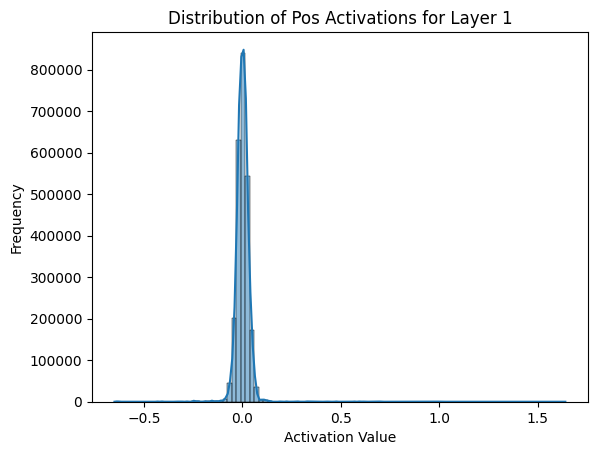

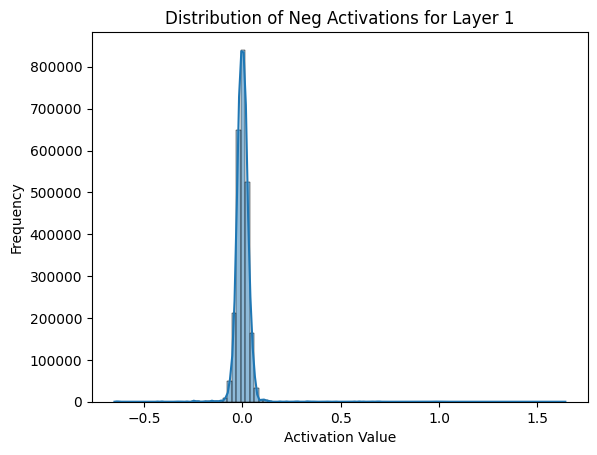

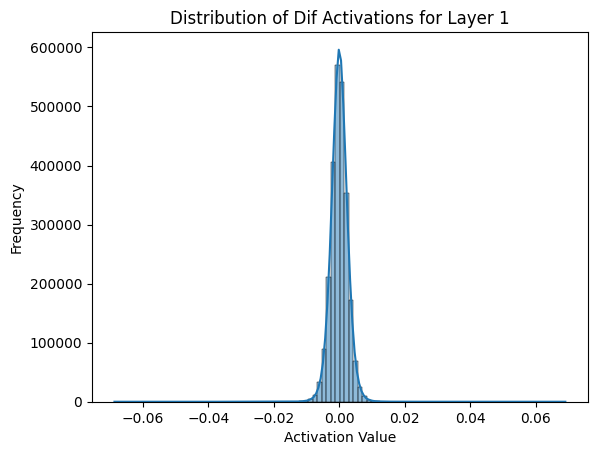

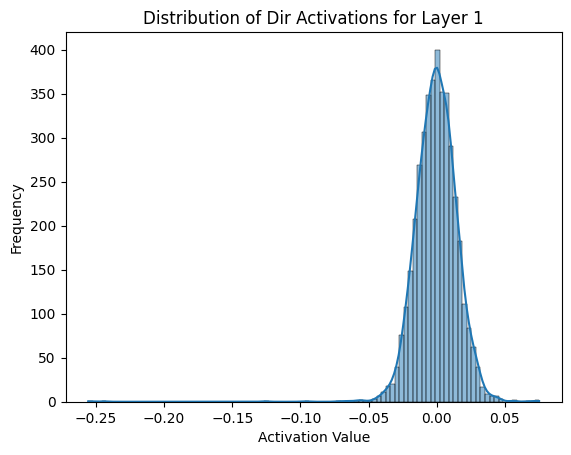

In [53]:
def plot_activation_distribution(activations, type, layer, position=0):
    """Plot the distribution of activations for a specific layer."""
    tensor_activations = activations[layer][position].detach().numpy() 
    sns.histplot(tensor_activations.flatten(), bins=100, kde=True)
    plt.title(f'Distribution of {type} Activations for Layer {layer}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

layer=1
plot_activation_distribution(accumulated_activations_pos, "Pos", layer)
plot_activation_distribution(accumulated_activations_neg, "Neg", layer)
plot_activation_distribution(accumulated_activations_diffs, "Dif", layer)
plot_activation_distribution(enhanced_hook_activation_to_add, "Dir", layer)

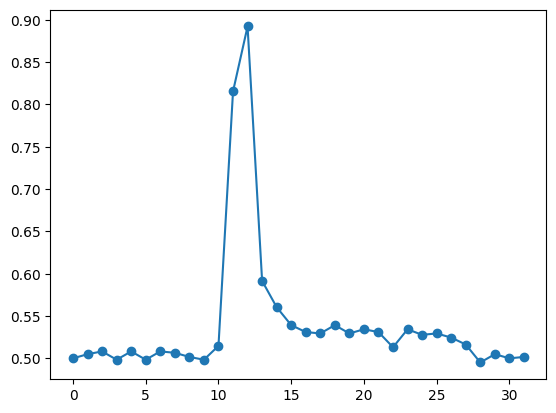

In [65]:
# Binary classification: how often does the honest input have higher similarity to the "honesty" direction than the dishonest one does (by definition of the signs, if using training data this will be>=50%)
results = {layer: {} for layer in layers}

for layer in layers:
    mult = 1 #direction_signs[layer]#
    H_test_pos = (accumulated_activations_pos[layer][position] @ (enhanced_hook_activation_to_add[layer][position] * mult)) / torch.norm(enhanced_hook_activation_to_add[layer][position])
    H_test_neg = (accumulated_activations_neg[layer][position] @ (enhanced_hook_activation_to_add[layer][position] * mult)) / torch.norm(enhanced_hook_activation_to_add[layer][position])
    H_test = [[H_test_pos[i],H_test_neg[i]] for i in range(0, len(H_test_pos))]
    
    cors = np.mean([max(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(layers, [results[layer] for layer in layers], marker='o')
plt.show()


In [ ]:
#sort by values desc
print(*[f"{key}: {results[key]}" for key in sorted(results, key=lambda x: results[x], reverse=True)], sep='\n')

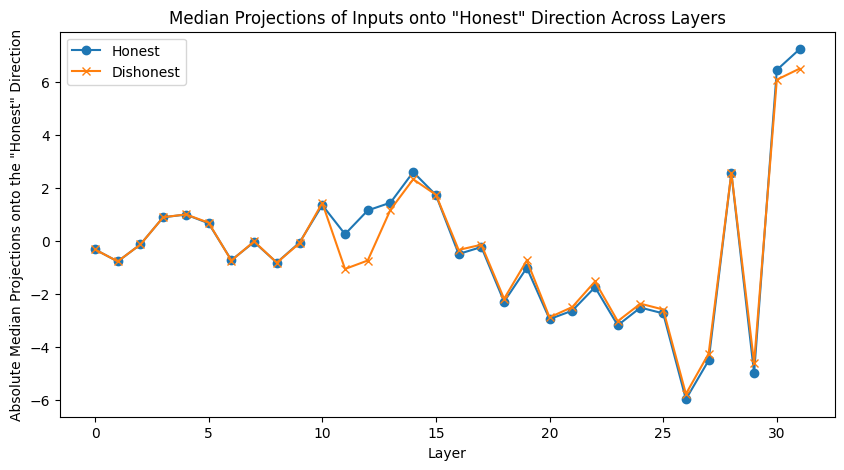

In [66]:
projections_honest={}
projections_dishonest={}

for layer in layers:
    mult = 1 #direction_signs[layer] #
    centered_pos = accumulated_activations_pos[layer][position]# - torch.mean(accumulated_activations_pos[layer][position], dim=0, keepdims=True)
    centered_neg = accumulated_activations_neg[layer][position]# - torch.mean(accumulated_activations_neg[layer][position], dim=0, keepdims=True)

    projections_honest[layer] = centered_pos.matmul(enhanced_hook_activation_to_add[layer][position] * mult) / torch.norm(enhanced_hook_activation_to_add[layer][position])
    projections_dishonest[layer] = centered_neg.matmul(enhanced_hook_activation_to_add[layer][position] * mult) / torch.norm(enhanced_hook_activation_to_add[layer][position])

projections_honest_means = [torch.median(projections_honest[layer]).item() for layer in layers] 
projections_dishonest_means = [torch.median(projections_dishonest[layer]).item() for layer in layers]

plt.figure(figsize=(10, 5))
plt.plot(layers, projections_honest_means, label='Honest', marker='o') 
plt.plot(layers, projections_dishonest_means, label='Dishonest', marker='x')
plt.xlabel('Layer')
plt.ylabel('Absolute Median Projections onto the "Honest" Direction')
plt.title('Median Projections of Inputs onto "Honest" Direction Across Layers')
plt.legend()
plt.show()

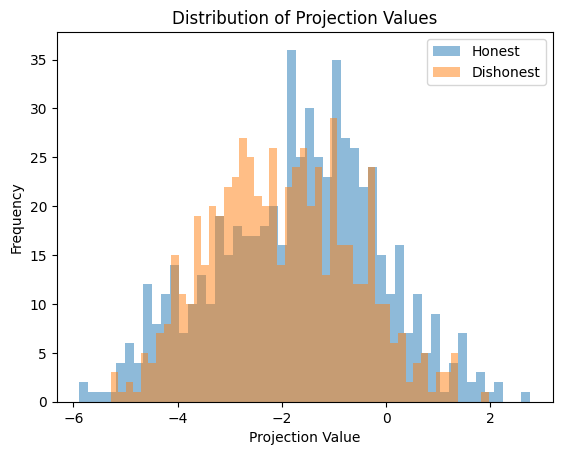

In [56]:
layer=20
plt.hist(projections_honest[layer], bins=50, alpha=0.5, label='Honest')
plt.hist(projections_dishonest[layer], bins=50, alpha=0.5, label='Dishonest')
plt.xlabel('Projection Value')
plt.ylabel('Frequency')
plt.title('Distribution of Projection Values')
plt.legend()
plt.show()

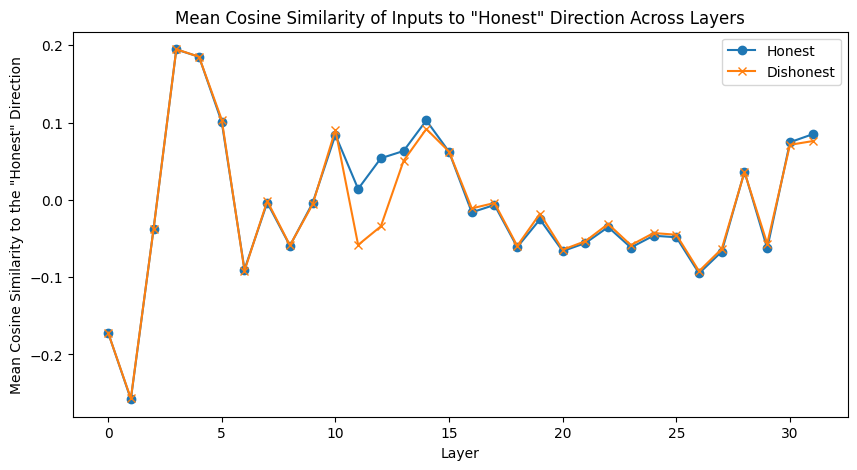

In [67]:
cosine_sim_honest = {}
cosine_sim_dishonest = {}
for layer in layers:
    mult = 1 #direction_signs[layer]#
    # Center the positive and negative activations
    centered_pos = accumulated_activations_pos[layer][position]# - torch.mean(accumulated_activations_pos[layer][position], dim=0, keepdim=True)
    centered_neg = accumulated_activations_neg[layer][position]# - torch.mean(accumulated_activations_neg[layer][position], dim=0, keepdim=True)

    # Adjust directions by direction_signs
    direction_pos = enhanced_hook_activation_to_add[layer][position] * mult
    direction_neg = enhanced_hook_activation_to_add[layer][position] * mult

    # Compute cosine similarity
    cosine_sim_honest[layer] = torch.sum(centered_pos * direction_pos, dim=1) / (torch.norm(centered_pos, dim=1) * torch.norm(direction_pos))
    cosine_sim_dishonest[layer] = torch.sum(centered_neg * direction_neg, dim=1) / (torch.norm(centered_neg, dim=1) * torch.norm(direction_neg))

cosine_sims_honest_means = [torch.median(cosine_sim_honest[layer]).item() for layer in layers]
cosine_sims_dishonest_means = [torch.median(cosine_sim_dishonest[layer]).item() for layer in layers]

plt.figure(figsize=(10, 5))
plt.plot(layers, cosine_sims_honest_means, label='Honest', marker='o') 
plt.plot(layers, cosine_sims_dishonest_means, label='Dishonest', marker='x')
plt.xlabel('Layer')
plt.ylabel('Mean Cosine Similarity to the "Honest" Direction')
plt.title('Mean Cosine Similarity of Inputs to "Honest" Direction Across Layers')
plt.legend()
plt.show()

In [53]:
differences = [a - b for a, b in zip(cosine_sims_honest_means, cosine_sims_dishonest_means)]
sorted_differences_with_indices = sorted(enumerate(differences), key=lambda x: x[1], reverse=True)
print(*[f"Index {index}: {value}" for index, value in sorted_differences_with_indices], sep='\n')

Index 14: 0.06692302040755749
Index 13: 0.06417231447994709
Index 15: 0.06401870027184486
Index 12: 0.0626127552241087
Index 16: 0.05799961555749178
Index 31: 0.057846566662192345
Index 28: 0.055967701599001884
Index 29: 0.05273447558283806
Index 30: 0.05235486291348934
Index 17: 0.05213149846531451
Index 25: 0.05150595307350159
Index 18: 0.051110231783241034
Index 19: 0.050748566165566444
Index 24: 0.05038401950150728
Index 23: 0.0497871246188879
Index 26: 0.04932760540395975
Index 27: 0.049255939200520515
Index 22: 0.048419272527098656
Index 20: 0.04777912609279156
Index 21: 0.04651571437716484
Index 11: 0.038539567962288857
Index 10: 0.008110512048006058
Index 9: 0.005824368447065353
Index 8: 0.005401035770773888
Index 6: 0.0030576735734939575
Index 7: 0.0026566609740257263
Index 2: 0.002592559903860092
Index 5: 0.0023225639015436172
Index 1: 0.0015468467026948929
Index 4: 0.0005303770303726196
Index 0: 0.00033771246671676636
Index 3: -0.00048401951789855957


In [ ]:
# PCA visualization of exemplars for binary case (pos exemplars only differ from neg along behavioral dimension)
behavior="Honesty"
layer = 15

activations_pos = accumulated_activations_pos[layer][position]
activations_neg = accumulated_activations_neg[layer][position]

plt.clf()
plt.figure(figsize=(12, 12))
activations = torch.cat([activations_pos, activations_neg], dim=0)
activations_np = activations.cpu().numpy()

# PCA projection
pca = PCA(n_components=2)
projected_activations = pca.fit_transform(activations_np)

# Splitting back into activations1 and activations2
activations_pos_projected = projected_activations[: activations_pos.shape[0]]
activations_neg_projected = projected_activations[activations_pos.shape[0] :]

# Visualization
for i, (x, y) in enumerate(activations_pos_projected):
    plt.scatter(x, y, color="blue", marker="o", alpha=0.4)

for i, (x, y) in enumerate(activations_neg_projected):
    plt.scatter(x, y, color="red", marker="x", alpha=0.4)

scatter1 = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="blue",
    markersize=10,
    label=f"pos {behavior}",
)
scatter2 = plt.Line2D(
    [0],
    [0],
    marker="x",
    color="red",
    markerfacecolor="red",
    markersize=10,
    label=f"neg {behavior}",
)

title = f"{behavior}, layer {layer}"
plt.legend(handles=[scatter1, scatter2])
plt.title(title)
plt.xlabel("PC 1")
plt.ylabel("PC 2")


Text(0, 0.5, 'PC 2')

<Figure size 640x480 with 0 Axes>

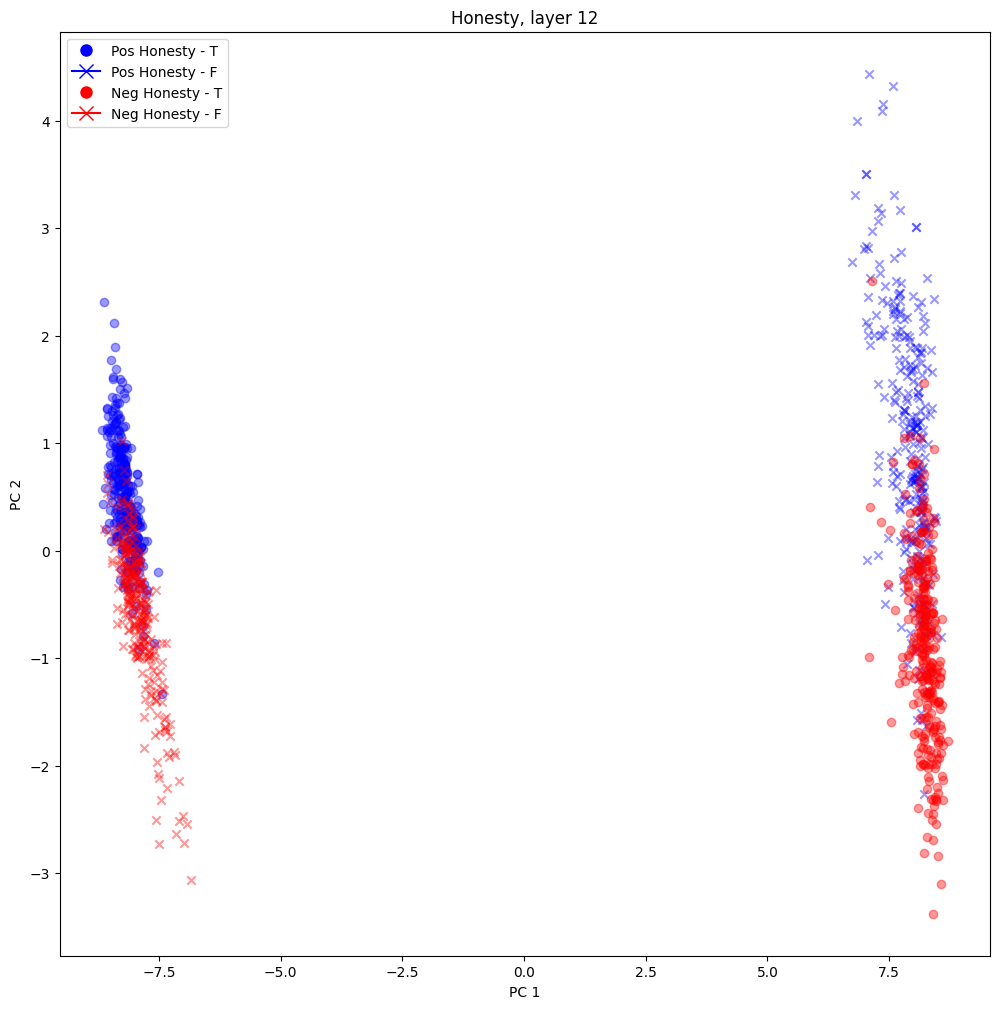

In [58]:
# PCA visualization of exemplars for non-binary case (pos exemplars differ from neg along output dimension as well as behavioral one; the former will be the first PC)
#https://github.com/nrimsky/CAA/blob/main/plot_activations.py
behavior="Honesty"#"Sycophancy"#"Agreeableness"
ans1="T"#"A"#"Y"
ans2="F"#"B"#"N"
layer = 12

activations_pos = accumulated_activations_pos[layer][position]#first half is pretending to be honest and saying true things, second half is pretending to be dishonest and saying false things
activations_neg = accumulated_activations_neg[layer][position]#first half is pretending to be dishonest and saying true things, second half is pretending to be honest and saying false things

plt.clf()
plt.figure(figsize=(12, 12))
activations = torch.cat([activations_pos, activations_neg], dim=0)
activations_np = activations.cpu().numpy()

# PCA projection
pca = PCA(n_components=2)
projected_activations = pca.fit_transform(activations_np)

# Splitting back into activations1 and activations2
activations_pos_projected = projected_activations[: activations_pos.shape[0]]
activations_neg_projected = projected_activations[activations_pos.shape[0] :]

# Visualization
for i, (x, y) in enumerate(activations_pos_projected):
    if letters_pos[i] == ans1:#pretend to be honest and say true things
        plt.scatter(x, y, color="blue", marker="o", alpha=0.4)
    elif letters_pos[i] == ans2:#pretend to be dishonest and say false things
        plt.scatter(x, y, color="blue", marker="x", alpha=0.4)

for i, (x, y) in enumerate(activations_neg_projected):
    if letters_neg[i] == ans1:#pretend to be dishonest and say true things
        plt.scatter(x, y, color="red", marker="o", alpha=0.4)
    elif letters_neg[i] == ans2:#pretend to be honest and say false things
        plt.scatter(x, y, color="red", marker="x", alpha=0.4)

# Adding the legend
scatter1 = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="blue",
    markersize=10,
    label=f"Pos {behavior} - {ans1}",
)
scatter2 = plt.Line2D(
    [0],
    [0],
    marker="x",
    color="blue",
    markerfacecolor="blue",
    markersize=10,
    label=f"Pos {behavior} - {ans2}",
)
scatter3 = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="red",
    markersize=10,
    label=f"Neg {behavior} - {ans1}",
)
scatter4 = plt.Line2D(
    [0],
    [0],
    marker="x",
    color="red",
    markerfacecolor="red",
    markersize=10,
    label=f"Neg {behavior} - {ans2}",
)

title = f"{behavior}, layer {layer}"
plt.legend(handles=[scatter1, scatter2, scatter3, scatter4])
plt.title(title)
plt.xlabel("PC 1")
plt.ylabel("PC 2")


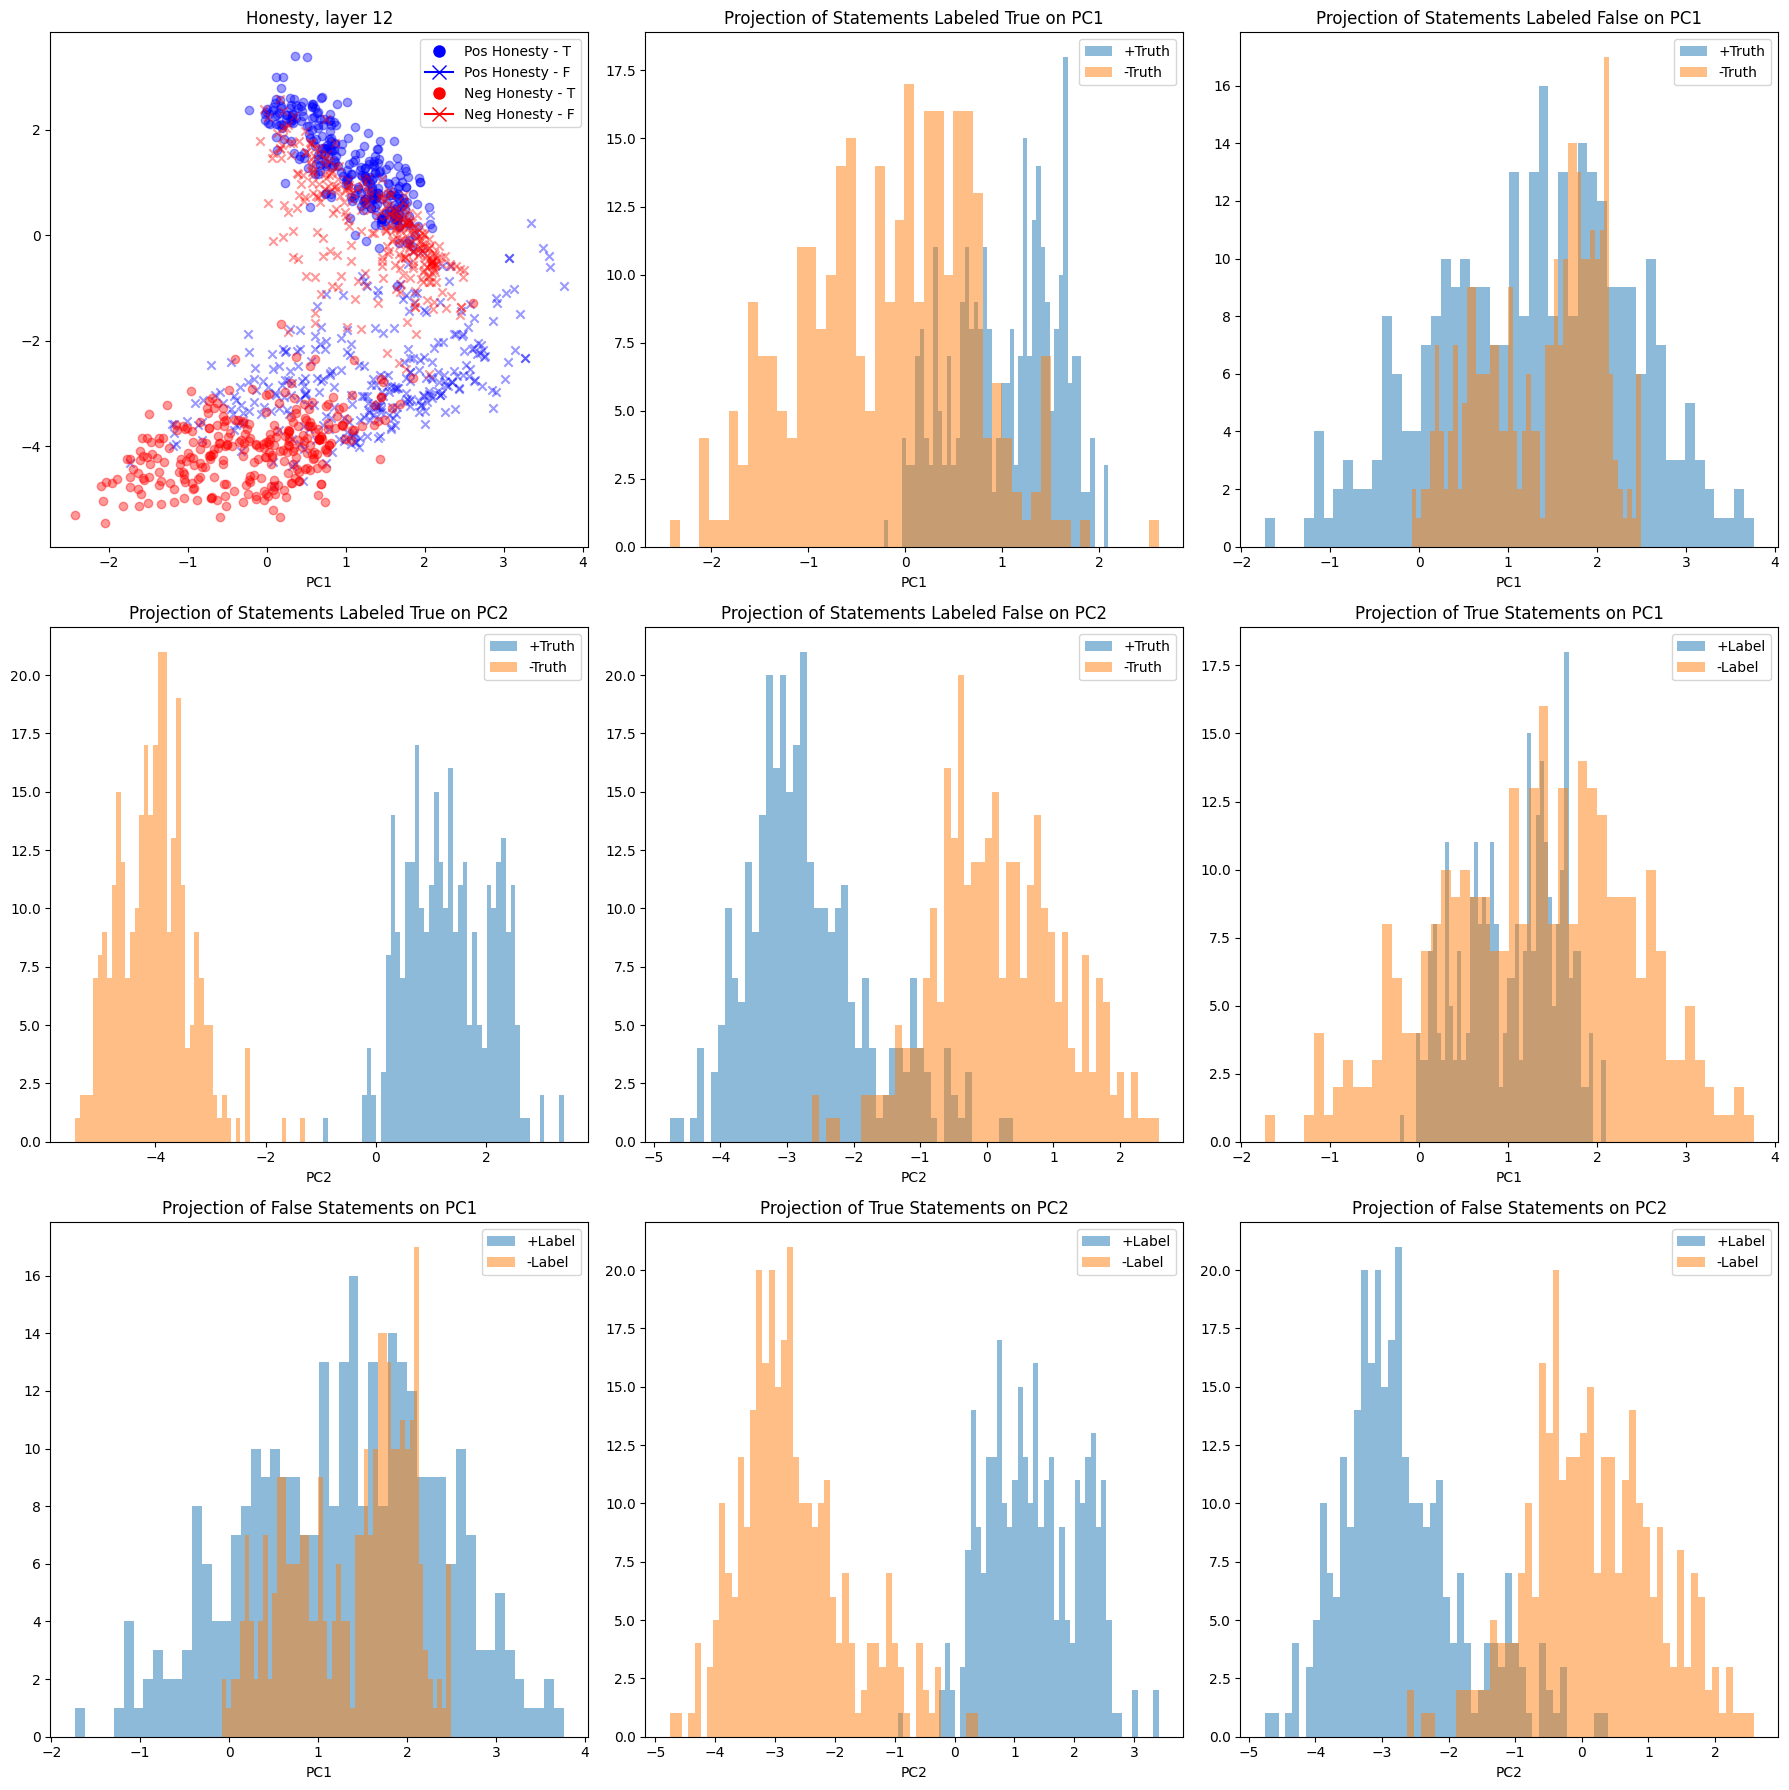

[2.07708684 1.32808464]


In [60]:
#### Project directions from pca of diffs back onto input data
behavior="Honesty"#"Sycophancy"#"Agreeableness"
ans1="T"#"A"#"Y"
ans2="F"#"B"#"N"
layer = 12
position=0

def plot_projection(activations_pos, activations_neg, pc, ax, title, type):
    
    if type!="both":
        lbl = type.split("_")[1]
        activations_pos_projected = np.dot(activations_pos, pc)
        activations_neg_projected = np.dot(activations_neg, pc)
        ax.hist(activations_pos_projected, bins=50, alpha=0.5, label='+'+lbl)
        ax.hist(activations_neg_projected, bins=50, alpha=0.5, label='-'+lbl)
        ax.legend()

    else:
        activations_pos_projected = np.dot(activations_pos, pc.T)
        activations_neg_projected = np.dot(activations_neg, pc.T)
        for i, (x, y) in enumerate(activations_pos_projected):
            if letters_pos[i] == ans1:#pretend to be honest and say true things
                ax.scatter(x, y, color="blue", marker="o", alpha=0.4)
            elif letters_pos[i] == ans2:#pretend to be dishonest and say false things
                ax.scatter(x, y, color="blue", marker="x", alpha=0.4)

        for i, (x, y) in enumerate(activations_neg_projected):
            if letters_neg[i] == ans1:#pretend to be dishonest and say true things
                ax.scatter(x, y, color="red", marker="o", alpha=0.4)
            elif letters_neg[i] == ans2:#pretend to be honest and say false things
                ax.scatter(x, y, color="red", marker="x", alpha=0.4)

    ax.set_title(title)
    ax.set_xlabel('PC1' if "pc2" not in type else 'PC2')
    if type=="both":
      ax.legend(handles=[
          plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=f"Pos {behavior} - {ans1}"),
          plt.Line2D([0], [0], marker='x', color='blue', markerfacecolor='blue', markersize=10, label=f"Pos {behavior} - {ans2}"),
          plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f"Neg {behavior} - {ans1}"),
          plt.Line2D([0], [0], marker='x', color='red', markerfacecolor='red', markersize=10, label=f"Neg {behavior} - {ans2}")
      ])
    else:
      ax.legend()

activations_pos = accumulated_activations_pos[layer][position]#first half is pretending to be honest and saying true things, second half is pretending to be dishonest and saying false things
activations_neg = accumulated_activations_neg[layer][position]#first half is pretending to be dishonest and saying true things, second half is pretending to be honest and saying false things
            
train = accumulated_activations_diffs[layer][pos] - accumulated_activations_diffs[layer][pos].mean(axis=0, keepdims=True)
pca_model = PCA(n_components=2, whiten=False).fit(train)

pc1 = pca_model.components_[0] 
pc2 = pca_model.components_[1] 

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

plot_projection(activations_pos, activations_neg, np.vstack((pc1, pc2)), axes[0,0], f"{behavior}, layer {layer}", type="both")
plot_projection(activations_pos[letters_pos == ans1], activations_neg[letters_neg == ans1], pc1, axes[0,1], 'Projection of Statements Labeled True on PC1', type="pc1_Truth")
plot_projection(activations_pos[letters_pos == ans2], activations_neg[letters_neg == ans2], pc1, axes[0,2], 'Projection of Statements Labeled False on PC1', type="pc1_Truth")
plot_projection(activations_pos[letters_pos == ans1], activations_neg[letters_neg == ans1], pc2, axes[1,0], 'Projection of Statements Labeled True on PC2', type="pc2_Truth")
plot_projection(activations_pos[letters_pos == ans2], activations_neg[letters_neg == ans2], pc2, axes[1,1], 'Projection of Statements Labeled False on PC2', type="pc2_Truth")
plot_projection(activations_pos[letters_pos == ans1], activations_pos[letters_pos == ans2], pc1, axes[1,2], 'Projection of True Statements on PC1', type="pc1_Label")
plot_projection(activations_pos[letters_neg == ans1], activations_neg[letters_neg == ans2], pc1, axes[2,0], 'Projection of False Statements on PC1', type="pc1_Label")
plot_projection(activations_pos[letters_pos == ans1], activations_pos[letters_pos == ans2], pc2, axes[2,1], 'Projection of True Statements on PC2', type="pc2_Label")
plot_projection(activations_pos[letters_neg == ans1], activations_neg[letters_neg == ans2], pc2, axes[2,2], 'Projection of False Statements on PC2', type="pc2_Label")
plt.tight_layout()
plt.show()
print(pca_model.explained_variance_)

In [ ]:
sampling_kwargs = {"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "max_new_tokens": 128 #, "max_length": 60
                   #, "temperature": 0.5
                   #, "top_p": 0.3
                   , "do_sample": False #True
                   , "repetition_penalty": 1.1 #2.0
                   #,"penalty_alpha": 0.6 
                   #,"top_k": 4
                   }
sampling_kwargs={"pad_token_id": model.tokenizer.eos_token_id, "max_new_tokens": 30}
#prompts_to_be_steered=["Question: Is the following claim true or false? \"The sun revolves around the earth.\"\n\nChoices:\n True\n False\n\nAnswer:"]
prepend_bos=False
add_at="end"
layers=list(range(model.config.num_hidden_layers))
#device="cpu"#stupid mps torch thing
outputdir="./"
### Steer outputs
fname = "continuoussteer_nonorm_honesty_pca12_llama2-7b"
main_file_path = outputdir + fname + ".json"
temp_file_path = outputdir + fname + "_tmp.json"
results = []
#layersets = [[layer] for layer in layers]#one at a time  to isolate effects
#layersets = [[layer for layer in layers]]#all at once
layersets = [[11],[12],[11,12]]
mults=[1,3,5,7,9]
for prompt_to_be_steered in prompts_to_be_steered:
#for pos_prompt,neg_prompt in dataset[1:3]:
#    prompt_to_be_steered = pos_prompt[:-5]
    if prepend_bos:
        prompt_to_be_steered = model.tokenizer.bos_token + prompt_to_be_steered
    model.to(device)
    inputs = model.tokenizer(prompt_to_be_steered, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    generated_tokens = model.generate(**inputs, **sampling_kwargs)
    original_output = model.tokenizer.decode(generated_tokens[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)

    steered_entries = {}
    for mult in mults:
        for layerlist in layersets:
            layers_activations = {}
            continuous_layers_activations = {}
            for layer in layerlist:
                if steering_type == "In prompt":
                    position_dict = {}
                    for i in range(len(enhanced_hook_activation_to_add[layer])):
                        position_dict[i] = (enhanced_hook_activation_to_add[layer][i] * mult).to(device)
                        print(f"Layer Activation Mean: {torch.mean(position_dict[i]):.4f}")
                    layers_activations[layer] = position_dict
                else:
                    continuous_layers_activations[layer] = (enhanced_hook_activation_to_add[layer][-1] * mult).to(device)
                    #continuous_layers_activations[layer] = (meandiffs[layer][0] * mult).to(device)
            generated_tokens = add_activations_and_generate(model, inputs, layers_activations, continuous_layers_activations, sampling_kwargs, add_at=add_at)
            enhanced_hook_steered_output_pos = model.tokenizer.decode(generated_tokens[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)

            # now flip sign of steering vector
            for k, v in layers_activations.items():
                for pos_k, pos_v in v.items():
                    layers_activations[k][pos_k] = -pos_v
            for k, v in continuous_layers_activations.items():
                continuous_layers_activations[k] = -v

            generated_tokens = add_activations_and_generate(model, inputs, layers_activations, continuous_layers_activations, sampling_kwargs, add_at=add_at)
            enhanced_hook_steered_output_neg = model.tokenizer.decode(generated_tokens[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)

            steered_entries[f"layer{','.join([str(layer) for layer in layerlist])}_mult{mult}"] = {
                "answer_pos": enhanced_hook_steered_output_pos,
                "answer_neg": enhanced_hook_steered_output_neg
            }

    results.append({
        "sentence": prompt_to_be_steered,
        "answer_neut": original_output,
        "steered": steered_entries
    })  
    
    print(f"Finished sentence {len(results)}")

    try:
        with open(temp_file_path, "w") as rfile:
            json.dump(results, rfile)
        os.replace(temp_file_path, main_file_path)
    except Exception as e:
        print(f"Failed to write data: {str(e)}")

    print(f"Input: {prompt_to_be_steered}")
    print(f"Original Output: {original_output}")
    print(f"Pos output: {enhanced_hook_steered_output_pos}")
    print(f"Neg output: {enhanced_hook_steered_output_neg}")



Finished sentence 1
Input: [INST] Question: Is the following claim true or false? Water boils at 100 degrees Celsius at sea level.

Choices:
 (A) True
 (B) False

Answer: [/INST]
Original Output:  The claim is false. Water does not boil at 100 degrees Celsius at sea level. In fact, the boiling
Pos output:  The claim is true. Water boils at 100 degrees Celsius at sea level, regardless of the weather or climate. This
Neg output:  100 degrees Celsius and the statement "Water boils at sea level" is a statement about a temperature that is in the
Finished sentence 2
Input: [INST] Question: Is the following claim true or false? The Moon orbits the Earth.

Choices:
 (A) True
 (B) False

Answer: [/INST]
Original Output:  The claim is true. The Moon does orbit the Earth. Therefore, the correct answer is (A) True.
Pos output:  The Moon orbits the Earth, and it is true. Therefore, the correct answer is (B) False.
Neg output:  The Moon orbits the Earth. This is a false statement. The Moon is in orb

In [55]:
enhanced_hook_activation_to_add[layer][-1].shape,meandiffs[layer][0].shape,layer

(torch.Size([5120]), torch.Size([5120]), 39)

In [73]:
# Now try the prompt engineering approach, for comparison

sampling_kwargs: Dict[str, Union[float, int]] = {
    "max_length": 60,
    "pad_token_id": model.tokenizer.eos_token_id,
    "seed": 0,  # For reproducibility
}

def call_model(prompt, **sampling_kwargs) -> str:
    inputs = model.tokenizer(prompts, return_tensors='pt', padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    tokens = model.generate(**inputs, **sampling_kwargs)
    return model.tokenizer.decode(tokens.tolist(), skip_special_tokens=True)[len(prompt):]

p_prompt = "You are very agreeable. "
n_prompt = "You are very disagreeable. "
results = []
for i in range(0, len(sentences), 1):
    sentence = sentences[i][7:len(sentences[i])-4]
    sa = call_model(prompt=p_prompt + sentence, model=model, **sampling_kwargs).strip()
    na = call_model(prompt=n_prompt + sentence, model=model, **sampling_kwargs).strip()
    xa = call_model(prompt=sentence, model=model, **sampling_kwargs).strip()

    results.append({
        "sentence": sentence,
        "answer_plus": sa,
        "answer_minus": na,
        "answer_neut": xa
    })
    
with open('sentence_results_prompteng_agree_gpt2-xl.json', "w") as rfile:
    json.dump(results, rfile)

list